In [ ]:
## 히스토그램은 제일 마지막에 있음.

In [4]:
## 데이터불러오기

In [5]:
import pandas as pd

df_train = pd.read_csv('combined_train_data.csv')
df_valid = pd.read_csv('combined_val_data.csv')


In [6]:
x_train = df_train.iloc[:, [3, 4] + list(range(6, df_train.shape[1]))]
y_train = df_train.iloc[:, 5]
x_valid = df_valid.iloc[:, [3, 4] + list(range(6, df_train.shape[1]))]
y_valid = df_valid.iloc[:, 5]

In [7]:
## 기본 작업

In [8]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [9]:
## 레이블 인코딩 작업

In [10]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels with value between 0 and n_classes-1
# XGBClassifier를 사용하기 위해 대상 레이블을 정수로 인코딩해야 합니다.
# 현재 대상 레이블은 범주형 문자열이므로, LabelEncoder를 사용하여 숫자로 변환해야 합니다.

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.transform(y_valid)

# got ['in' 'noise' 'normal' 'other' 'out']---> 클래스를 정수로 인코딩: [0 1 2 3 4]

In [11]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
# XGBoost 모델 설정
params = {
    'base_score': 0.5, 
    'booster': 'gbtree', 
    'colsample_bylevel': 1,
    'colsample_bynode': 1, 
    'colsample_bytree': 1, 
    'eval_metric': 'mlogloss',
    'gamma': 0, 
    'importance_type': 'gain',
    'interaction_constraints': '', 
    'learning_rate': 0.5, 
    'max_delta_step': 0,
    'max_depth': 6, 
    'min_child_weight': 1,
    'monotone_constraints': '()', 
    'n_estimators': 100, 
    'n_jobs': 0,
    'num_class': 5, 
    'num_parallel_tree': 1, 
    'objective': 'multi:softprob',
    'random_state': 42, 
    'reg_alpha': 0, 
    'reg_lambda': 1, 
    'scale_pos_weight': None,
    'seed': 42, 
    'subsample': 1, 
    'tree_method': 'exact', 
    'validate_parameters': 1,
    'verbosity': None
}

In [13]:
## DMatrix 생성

In [14]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)

In [15]:
num_rounds = 100
evals = [(dtrain, 'train'), (dvalid, 'valid')]  # 평가용 데이터 세트
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, evals=evals, verbose_eval=True)

C:\Users\조여원\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [15:26:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "importance_type", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mlogloss:1.12414	valid-mlogloss:1.13480
[1]	train-mlogloss:0.94575	valid-mlogloss:0.96344
[2]	train-mlogloss:0.83826	valid-mlogloss:0.85997
[3]	train-mlogloss:0.77027	valid-mlogloss:0.79631
[4]	train-mlogloss:0.72161	valid-mlogloss:0.75142
[5]	train-mlogloss:0.68685	valid-mlogloss:0.71823
[6]	train-mlogloss:0.66050	valid-mlogloss:0.69300
[7]	train-mlogloss:0.63892	valid-mlogloss:0.67507
[8]	train-mlogloss:0.61882	valid-mlogloss:0.65665
[9]	train-mlogloss:0.59976	valid-mlogloss:0.63950
[10]	train-mlogloss:0.58327	valid-mlogloss:0.62625
[11]	train-mlogloss:0.57106	valid-mlogloss:0.61605
[12]	train-mlogloss:0.55073	valid-mlogloss:0.60057
[13]	train-mlogloss:0.53616	valid-mlogloss:0.58855
[14]	train-mlogloss:0.52273	valid-mlogloss:0.57750
[15]	train-mlogloss:0.50963	valid-mlogloss:0.56564
[16]	train-mlogloss:0.49550	valid-mlogloss:0.55336
[17]	train-mlogloss:0.47866	valid-mlogloss:0.54071
[18]	train-mlogloss:0.46863	valid-mlogloss:0.53221
[19]	train-mlogloss:0.45657	valid-mloglos

In [16]:
## 모델 예측

In [17]:
y_pred_train = model.predict(dtrain)
y_pred_valid = model.predict(dvalid)

In [18]:
## 모델 평가

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_true, y_pred):
    confusion = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Confusion Matrix:")
    print(confusion)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# 학습 데이터와 검증 데이터 예측
y_pred_train = model.predict(dtrain)
y_pred_valid = model.predict(dvalid)

# 학습 데이터 평가
print("Training Data Evaluation:")
get_clf_eval(y_train, np.argmax(y_pred_train, axis=1))

# 검증 데이터 평가
print("\nValidation Data Evaluation:")
get_clf_eval(y_valid, np.argmax(y_pred_valid, axis=1))


Training Data Evaluation:
Confusion Matrix:
[[13007    18     0    51   197]
 [    6  4979     0    13    31]
 [    0     0 19704     0     0]
 [   58    16     0  6839   106]
 [  106    17     0    60 17356]]
Accuracy: 0.9891, Precision: 0.9892, Recall: 0.9891, F1-score: 0.9891

Validation Data Evaluation:
Confusion Matrix:
[[1496   31    0   28  104]
 [  37  514    0   24   54]
 [   0    0 2462    0    0]
 [  50   31    0  697  100]
 [  85   24    0   22 2061]]
Accuracy: 0.9246, Precision: 0.9246, Recall: 0.9246, F1-score: 0.9239


In [20]:
## Feature importance 계산

In [21]:
## 전제 Feature importance

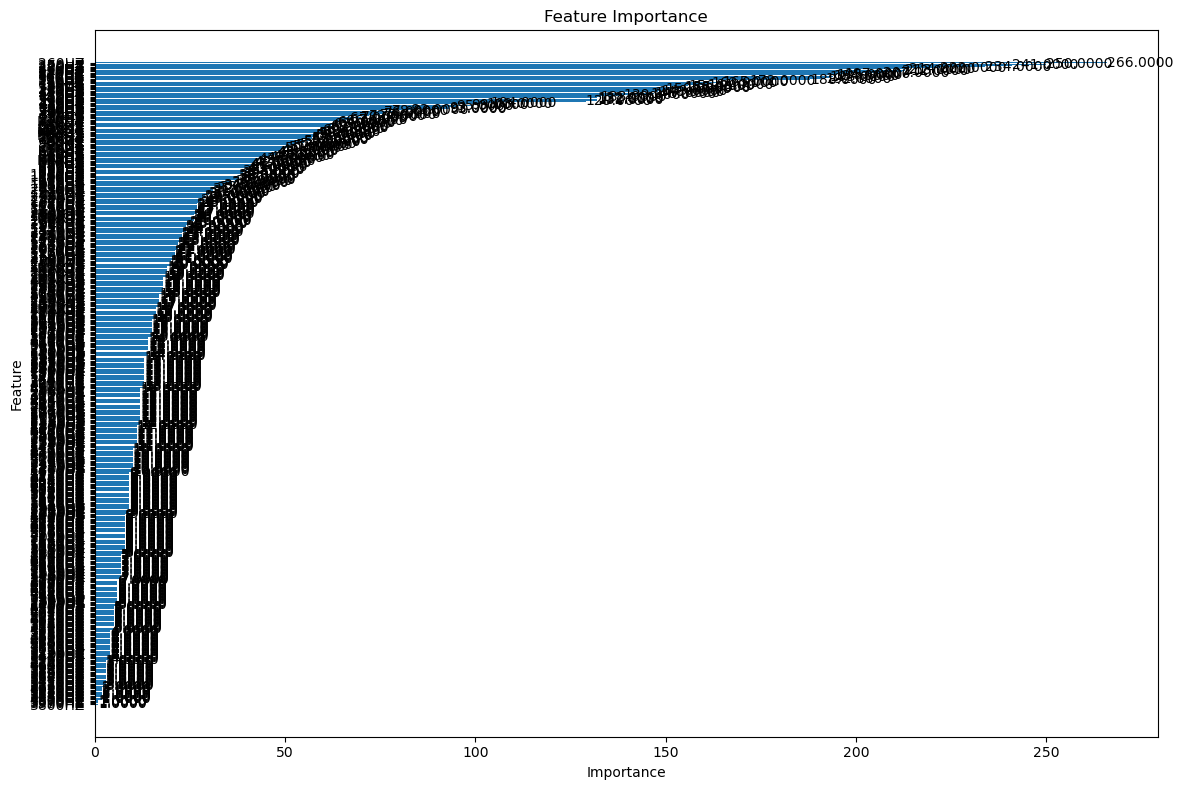

In [22]:
import matplotlib.pyplot as plt

# 피처 중요도 추출
importance = model.get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
feature_names = [x[0] for x in sorted_importance]
importance_values = [x[1] for x in sorted_importance]

# 중요도를 가지고 있는 데이터프레임 생성
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_values
})

# 중요도 순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(12, 8))

bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')

for bar, importance in zip(bars, feature_importance_df['Importance']):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f'{importance:.4f}', 
             va='center', ha='left', fontsize=10, color='black')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

plt.tight_layout()
plt.show()


In [23]:
## Feature importance 높은 순으로 feature 30개당 그래프 그리기

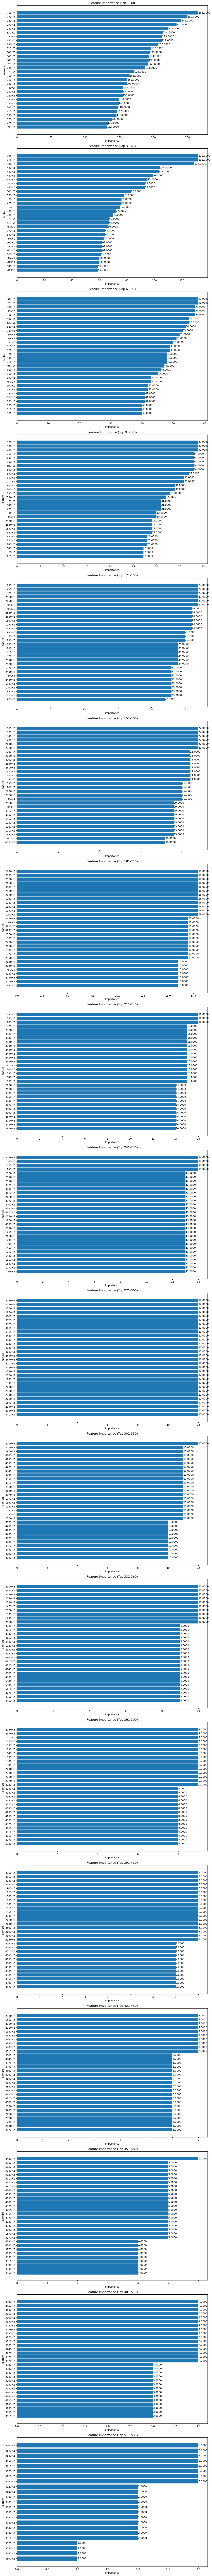

In [24]:
import matplotlib.pyplot as plt

# 피처 중요도 추출
importance = model.get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
feature_names = [x[0] for x in sorted_importance]
importance_values = [x[1] for x in sorted_importance]

# 중요도를 가지고 있는 데이터프레임 생성
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_values
})

# 중요도 순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 피처를 30개씩 나누어 그래프 생성
num_features = len(feature_importance_df)
num_subplots = (num_features // 30) + 1

plt.figure(figsize=(12, 8*num_subplots))

for i in range(num_subplots):
    start_idx = i * 30
    end_idx = min((i + 1) * 30, num_features)
    
    subset_df = feature_importance_df.iloc[start_idx:end_idx]
    subset_df = subset_df.sort_values(by='Importance', ascending=True)  # 중요도가 높은 순으로 정렬
    
    plt.subplot(num_subplots, 1, i+1)
    bars = plt.barh(subset_df['Feature'], subset_df['Importance'], align='center')
    
    for bar, importance in zip(bars, subset_df['Importance']):
        plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f'{importance:.4f}', 
                 va='center', ha='left', fontsize=10, color='black')

    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance (Top {start_idx+1}-{end_idx})')

plt.tight_layout()
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

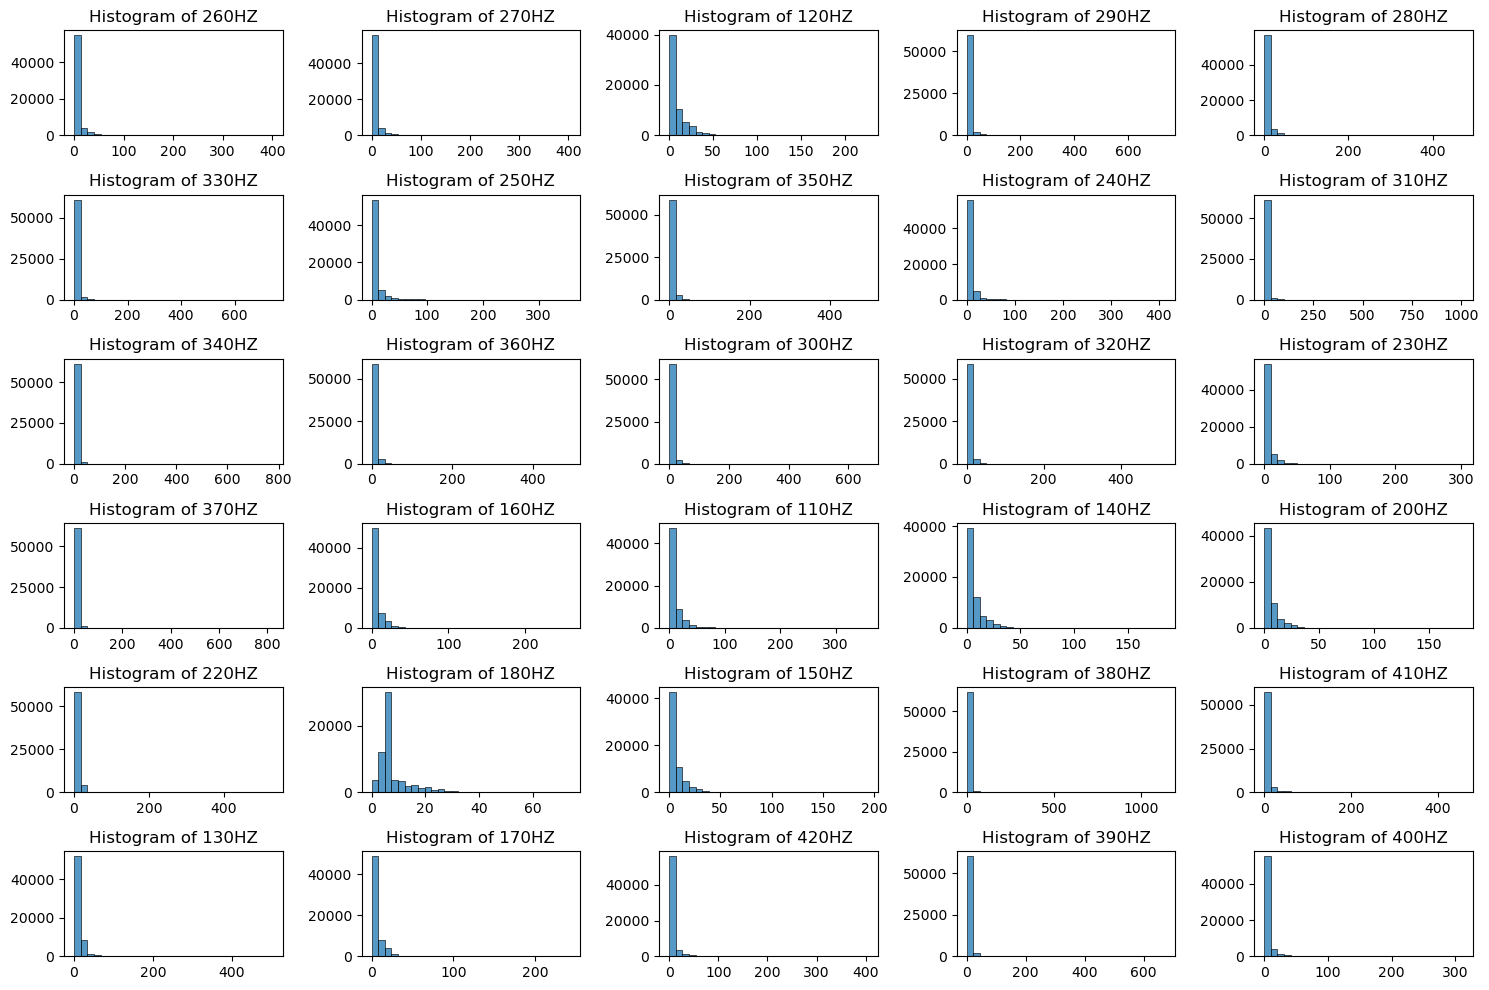

In [26]:
# 'llevel' 변수를 제외하고 상위 30개 피처 선택
top_30_features = feature_importance_df[~feature_importance_df['Feature'].str.contains('llevel')].head(30)['Feature'].values

# 히스토그램 그리기
plt.figure(figsize=(15, 10))

for i, feature in enumerate(top_30_features):
    # 피처 이름에서 숫자 부분 추출 (예: '60HZ'에서 '60' 추출)
    feature_index = int(''.join(filter(str.isdigit, feature)))
    
    plt.subplot(6, 5, i + 1)
    sns.histplot(x_train.iloc[:, feature_index], kde=False, bins=30)
    plt.title(f'Histogram of {feature}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

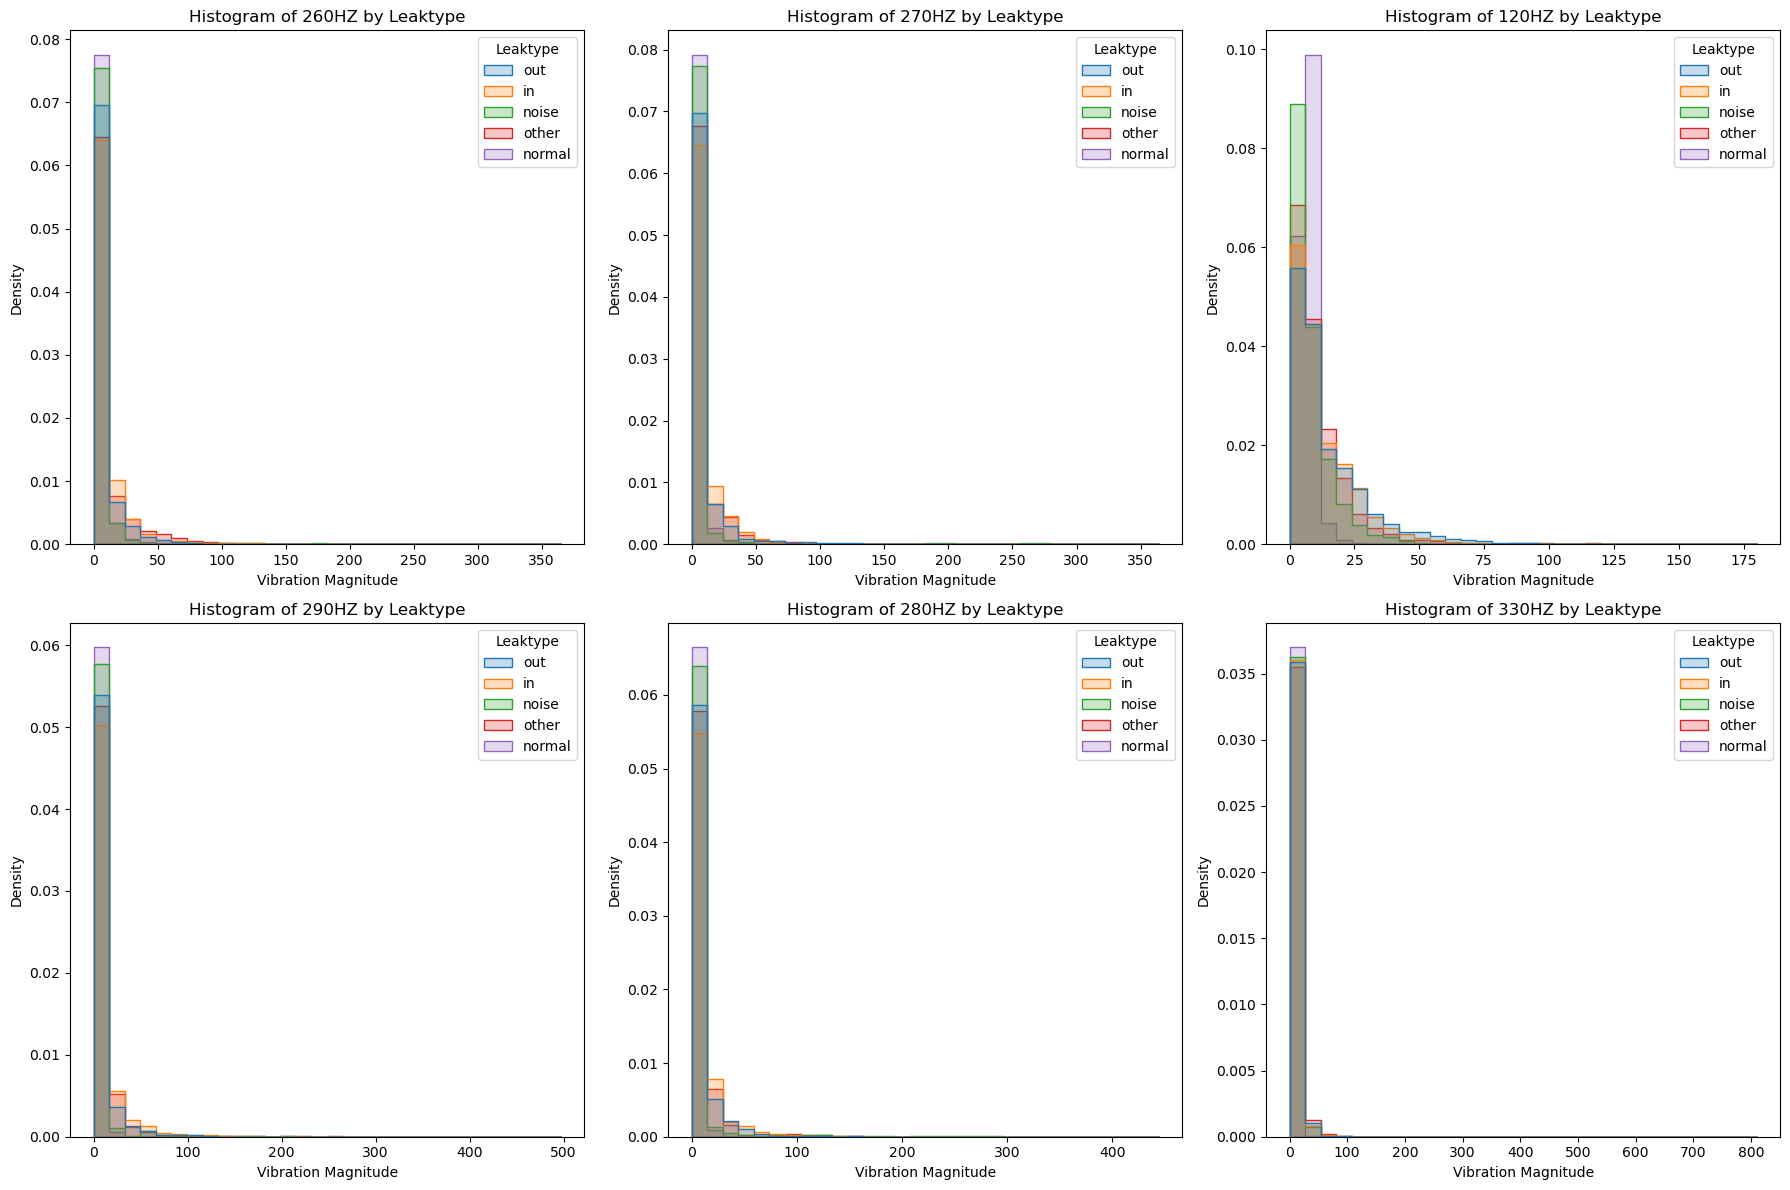

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

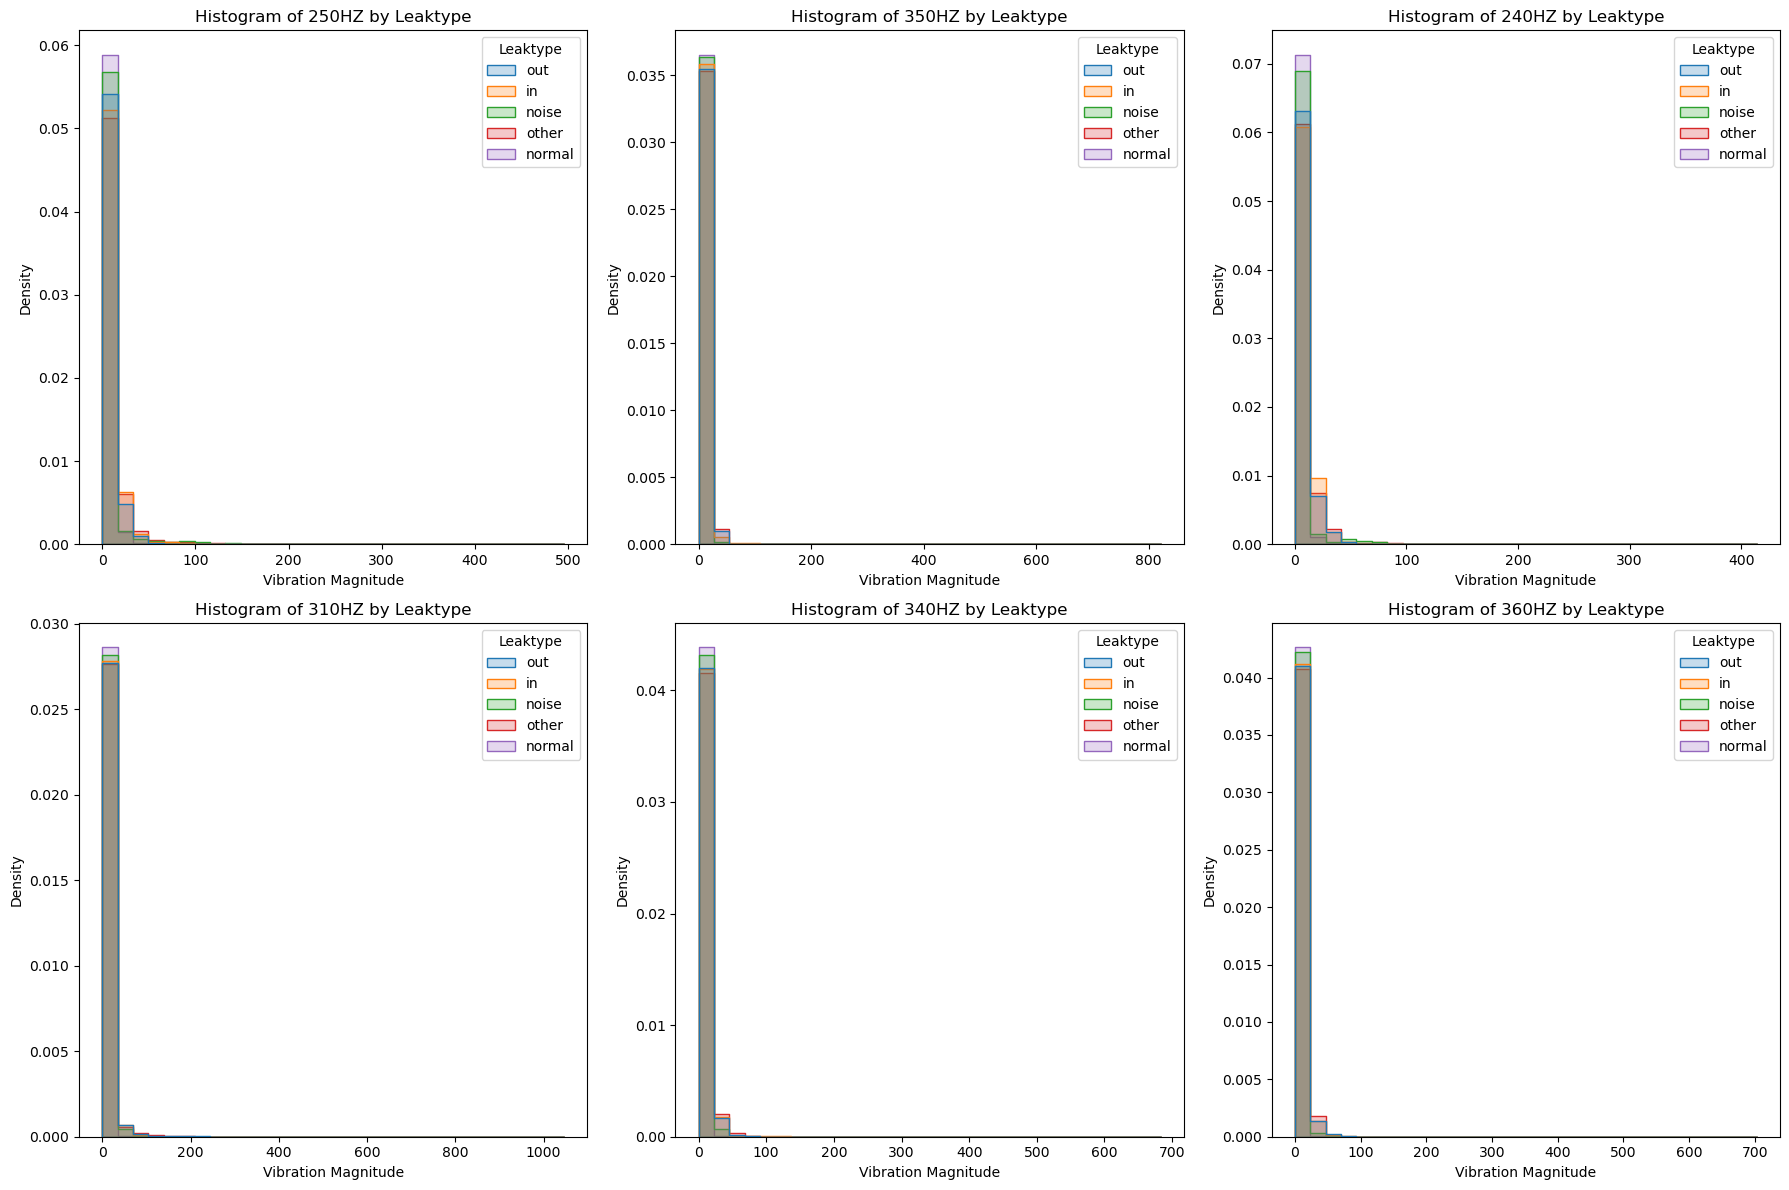

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

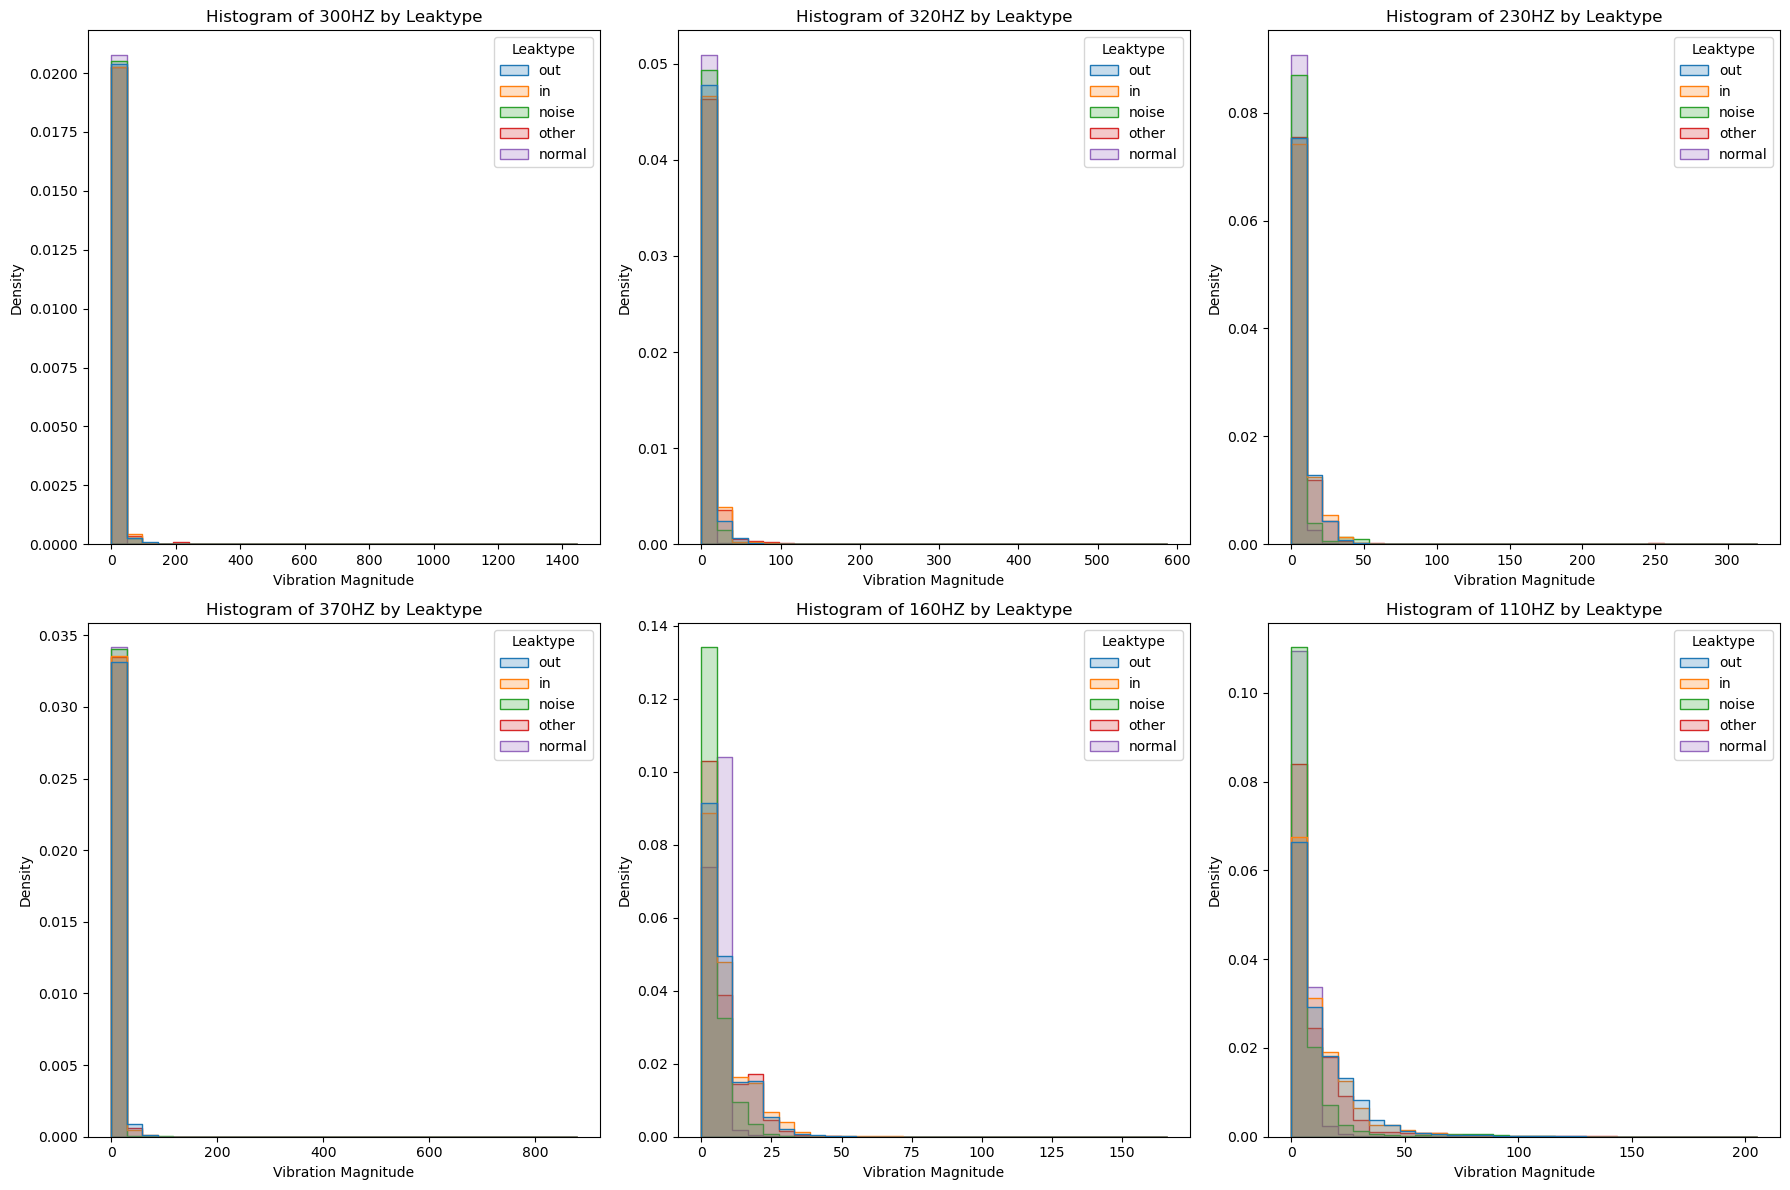

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

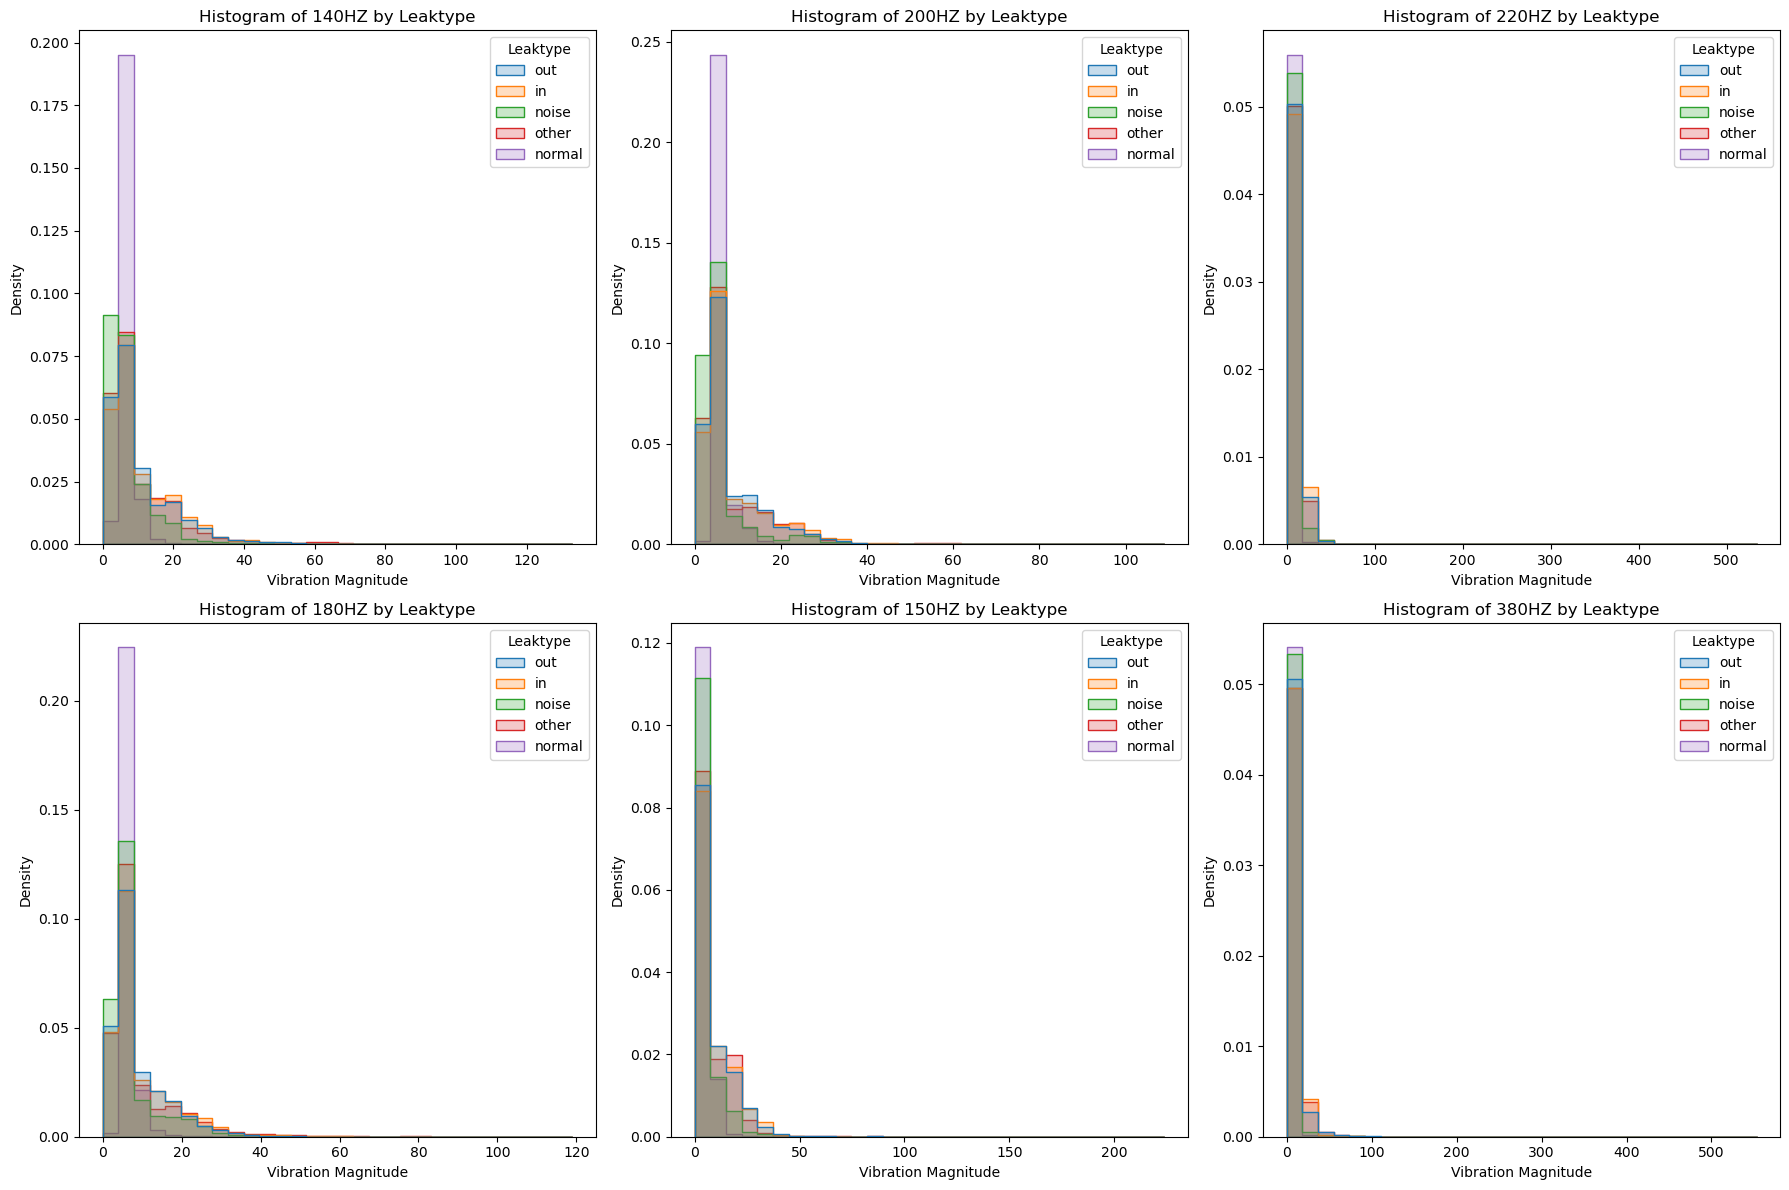

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

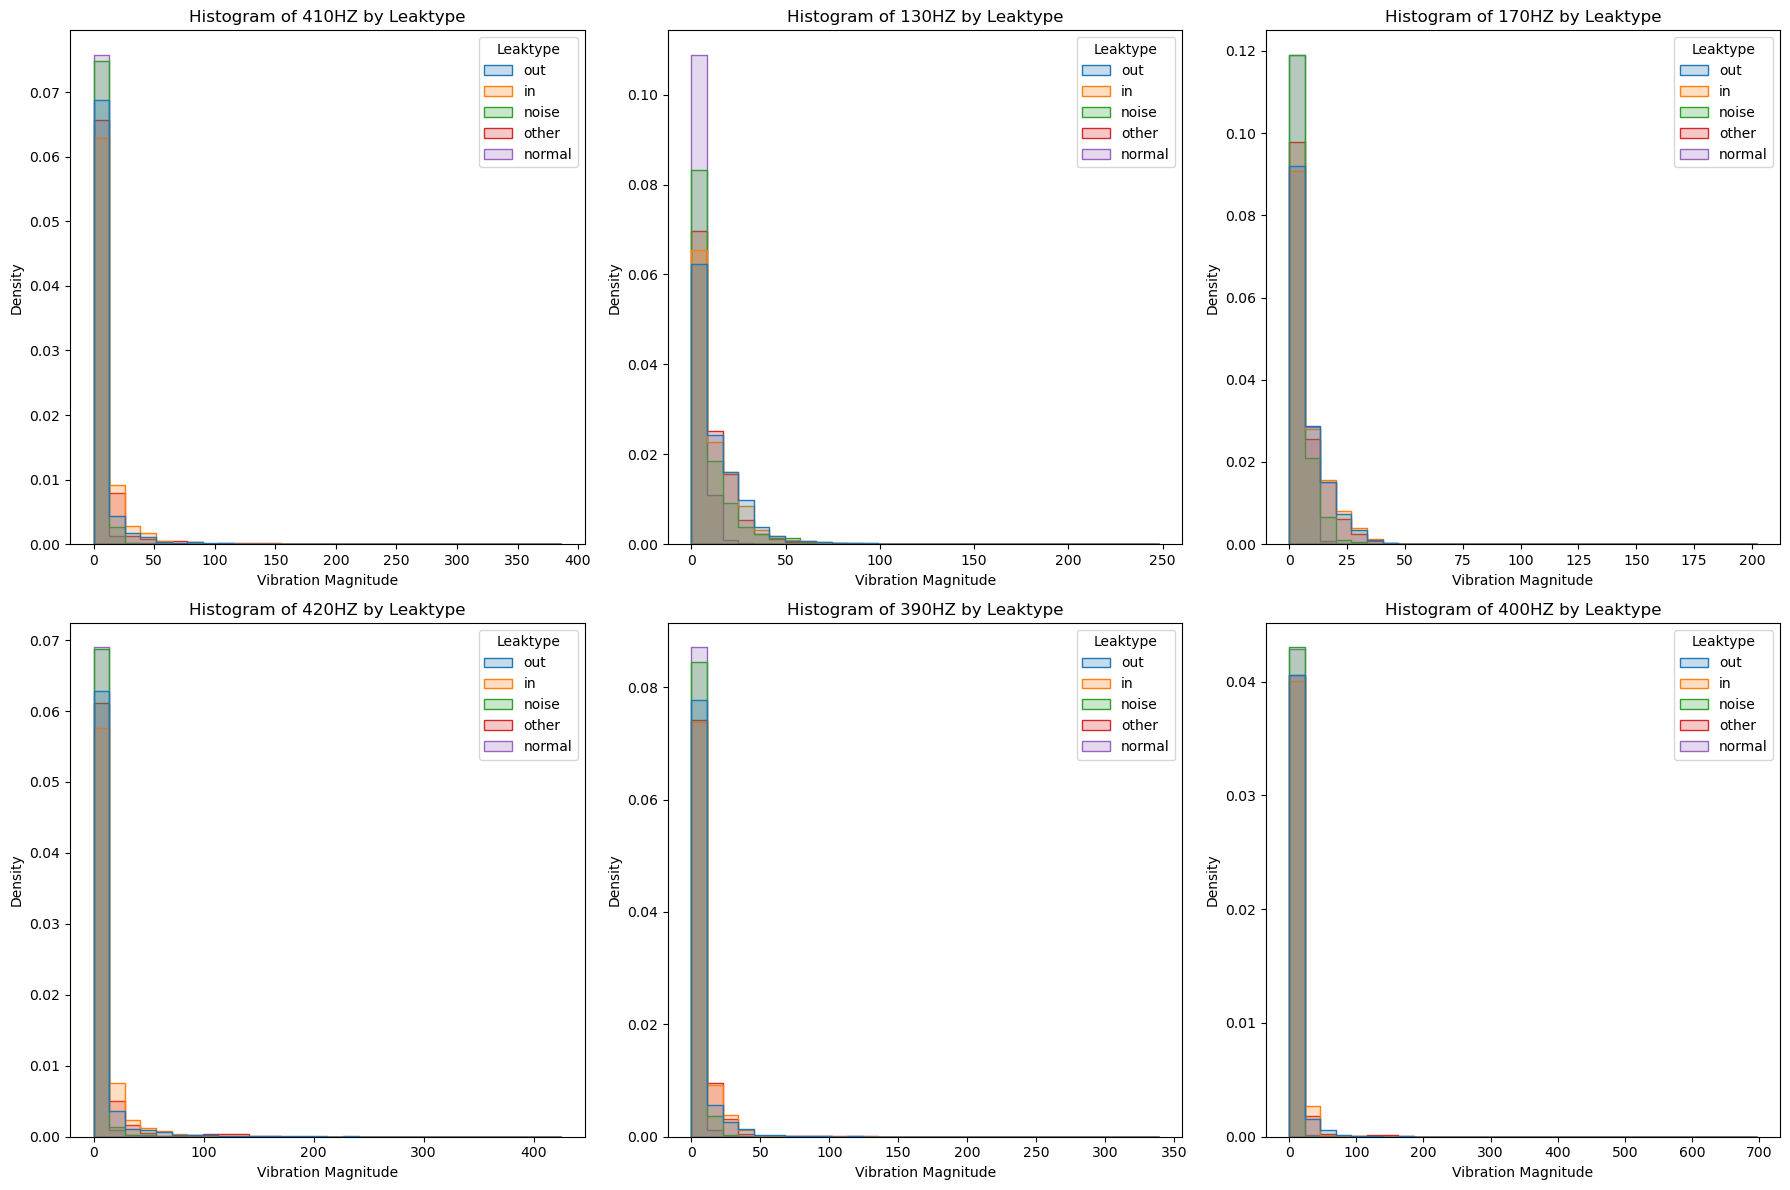

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 상위 30개 피처 선택
top_30_features = feature_importance_df[~feature_importance_df['Feature'].str.contains('llevel')].head(30)['Feature'].values

# 히스토그램 그리기
plt.figure(figsize=(18, 12))  # 전체 그림의 사이즈 설정
for i, feature in enumerate(top_30_features):
    # 피처 이름에서 숫자 부분 추출 (예: '60HZ'에서 '60' 추출)
    feature_index = int(''.join(filter(str.isdigit, feature)))
    
    # subplot 위치 계산 (한 줄에 3개씩 배치)
    plt.subplot(2, 3, i % 6 + 1)  # i % 6 + 1은 1부터 6까지의 값을 순환하게 설정
    
    # 히스토그램 그리기
    histplot = sns.histplot(data=df_train, x=df_train.iloc[:, feature_index], hue='leaktype', kde=False, element='step', stat='density', common_norm=False, bins=30)
    histplot.legend_.set_title('Leaktype')  # 범례 제목 설정
    plt.title(f'Histogram of {feature} by Leaktype')
    plt.xlabel('Vibration Magnitude')
    plt.ylabel('Density')

    # 한 줄에 3개씩 그래프 배치를 위한 처리
    if (i + 1) % 6 == 0 or i == len(top_30_features) - 1:
        plt.tight_layout()
        plt.show()
        if i != len(top_30_features) - 1:
            plt.figure(figsize=(18, 12))  # 새로운 subplot 준비
